# Mean-variance optimization

In [40]:
from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def calc_cov(deviations: np.ndarray, cor: np.ndarray) -> np.ndarray:
    """
    This function calculates the covariance matrix based on a given correlation matrix and array of standard deviations.

    Args:
    - deviations (np.ndarray): 1D array of standard deviations for each variable.
    - cor (np.ndarray): 2D correlation matrix.

    Returns:
    - 2D covariance matrix calculated from the input arrays.
    """
    # Calculate the outer product of the standard deviations to get a matrix of variances
    variances = np.outer(deviations, deviations)
    
    # Calculate the covariance matrix by element-wise multiplication of the correlation matrix with the variance matrix
    return cor * variances

def portolio_return(weights, returns):
    return np.dot(weights, returns)

def portfolio_variance(weights, cov_matrix):
    port_variance = np.dot(np.dot(weights, cov_matrix), weights.T)
    return port_variance

def sharpe_ratio(weights, returns, cov_matrix, rf_return):
    return (portolio_return(weights, returns) - rf_return) / \
        (portfolio_variance(weights, cov_matrix)**0.5)

def find_mve(returns, cov_matrix, rf_return):
    """
    This is a function to find the weights of a Mean-variance Efficient Portfolio (MVE) that maximizes the Sharpe Ratio.

    Parameters
    ----------
    - returns:   : an array of expected returns for each asset in the portfolio
    - cov_matrix : a covariance matrix for the assets in the portfolio
    - rf_return  : the risk-free return

    Returns
    -------
    The function returns a pandas Series object, containing:
    - w1..n: the optimal weights for each asset in the portfolio
    - Return: the expected return of the portfolio
    - Deviation: the expected standard deviation of the portfolio
    - Sharpe Ratio: the Sharpe Ratio of the portfolio
    """    
    # Constraints: weights must sum up to 1
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds on weights: each weight must be between 0 and 1
    bnds = [(0, 1) for i in range(0, len(cov_matrix))]

    # Initial guess of equal weights for each asset
    init_guess = [1/len(cov_matrix) for i in range(0, len(cov_matrix))]

    # Solve the optimization problem
    opt_results = minimize(
        lambda w: -sharpe_ratio(w, returns, cov_matrix, rf_return), 
        init_guess, 
        constraints=cons, 
        bounds=bnds)
    weights = opt_results.x
    p_return = portolio_return(weights, returns)
    p_deviation = portfolio_variance(weights, cov_matrix)**0.5
    sr = sharpe_ratio(weights, returns, cov_matrix, rf_return)
    labels = np.append(['w' + str(i) for i in range(1, len(weights)+1)], 
        ['Return', 'Deviation', 'Sharpe Ratio'])
    return pd.Series(np.append(weights, [p_return, p_deviation, sr]), index=labels)

def find_gmv(returns, cov_matrix, rf_return):
    # Constraints: weights must sum up to 1
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds on weights: each weight must be between 0 and 1
    bnds = [(0, 1) for i in range(0, len(cov_matrix))]

    # Initial guess of equal weights for each asset
    init_guess = [1/len(cov_matrix) for i in range(0, len(cov_matrix))]

    # Solve the optimization problem
    opt_results = minimize(
        lambda w: portfolio_variance(w, cov_matrix), 
        init_guess, 
        constraints=cons, 
        bounds=bnds
        )
    weights = opt_results.x
    p_return = portolio_return(weights, returns)
    p_deviation = portfolio_variance(weights, cov_matrix)**0.5
    sr = sharpe_ratio(weights, returns, cov_matrix, rf_return)
    labels = np.append(['w' + str(i) for i in range(1, len(weights)+1)], 
        ['Return', 'Deviation', 'Sharpe Ratio'])
    return pd.Series(np.append(weights, [p_return, p_deviation, sr]), index=labels)

## Plot the minimum variance frontier

You are given the expected return, volatility and correlation matrix assumptions for seven asset classes:

In [41]:
assets_df = pd.DataFrame({
  'Return': [0.04, 0.106, 0.083, 0.119, 0.128, 0.062],
  'Deviation': [0.068, 0.224, 0.221, 0.3, 0.231, 0.068]
}, index=['U.S. Bonds', 'U.S. Equity', 'Developed markets equity', 'Emerging markets equity', 'Private equity', 'Real Assets'])

asset_cor = pd.DataFrame({
  'U.S. Bonds': [1, 0.4, 0.25, 0.2, 0.15, 0.2],
  'U.S. Equity': [0.4, 1, 0.7, 0.6, 0.7, 0.2],
  'Developed markets equity': [0.25, 0.7, 1, 0.75, 0.6, 0.1],
  'Emerging markets equity': [0.2, 0.6, 0.75, 1, 0.25, 0.15],
  'Private equity': [0.15, 0.7, 0.6, 0.25, 1, 0.3],
  'Real Assets': [0.2, 0.2, 0.1, 0.15, 0.3, 1],
}, index=['U.S. Bonds', 'U.S. Equity', 'Developed markets equity', 'Emerging markets equity', 'Private equity', 'Real Assets'])

# risk-free return
rf_return = 0.03

asset_cov = calc_cov(assets_df['Deviation'], asset_cor.to_numpy())
asset_cov

array([[0.004624 , 0.0060928, 0.003757 , 0.00408  , 0.0023562, 0.0009248],
       [0.0060928, 0.050176 , 0.0346528, 0.04032  , 0.0362208, 0.0030464],
       [0.003757 , 0.0346528, 0.048841 , 0.049725 , 0.0306306, 0.0015028],
       [0.00408  , 0.04032  , 0.049725 , 0.09     , 0.017325 , 0.00306  ],
       [0.0023562, 0.0362208, 0.0306306, 0.017325 , 0.053361 , 0.0047124],
       [0.0009248, 0.0030464, 0.0015028, 0.00306  , 0.0047124, 0.004624 ]])

Find the mean variance efficient portfolio (MVE)

In [46]:
mve = find_mve(assets_df['Return'], asset_cov, rf_return)
np.round(mve, decimals=3)

w1              0.000
w2              0.000
w3              0.000
w4              0.082
w5              0.166
w6              0.752
Return          0.078
Deviation       0.082
Sharpe Ratio    0.581
dtype: float64

Find the minimum variance portfolio (GMV)

In [48]:
gmv = find_gmv(assets_df['Return'], asset_cov, rf_return)
np.round(gmv, decimals=4)

w1              0.4951
w2              0.0000
w3              0.0002
w4              0.0000
w5              0.0000
w6              0.5046
Return          0.0511
Deviation       0.0527
Sharpe Ratio    0.4008
dtype: float64

Construct mean variance frontier

In [44]:
# calculate correlation of gmv and mve
gmv_mve_cor = np.dot(gmv[:-3], np.dot(mve[:-3], asset_cov))
mvf_cov = np.array([
  [gmv['Deviation']**2, gmv_mve_cor],
  [gmv_mve_cor, mve['Deviation']**2],
])

mvf = pd.DataFrame({ 'gmv_w': np.arange(-1.1, 2.2, step=0.1) })
mvf['mve_w'] = 1 - mvf['gmv_w']
weights = mvf[['gmv_w', 'mve_w']].values
mvf['Return'] = np.dot(mvf[['gmv_w', 'mve_w']], [gmv['Return'], mve['Return']])
mvf['Deviation'] = np.sqrt(np.sum(np.dot(weights, mvf_cov) * weights, axis=1))
mvf.tail()

,gmv_w,mve_w,Return,Deviation
28,1.7,-0.7,0.032558,0.064888
29,1.8,-0.8,0.029907,0.068538
30,1.9,-0.9,0.027257,0.072491
31,2.0,-1.0,0.024606,0.076700
32,2.1,-1.1,0.021956,0.081125


Plot the mean variance frontier

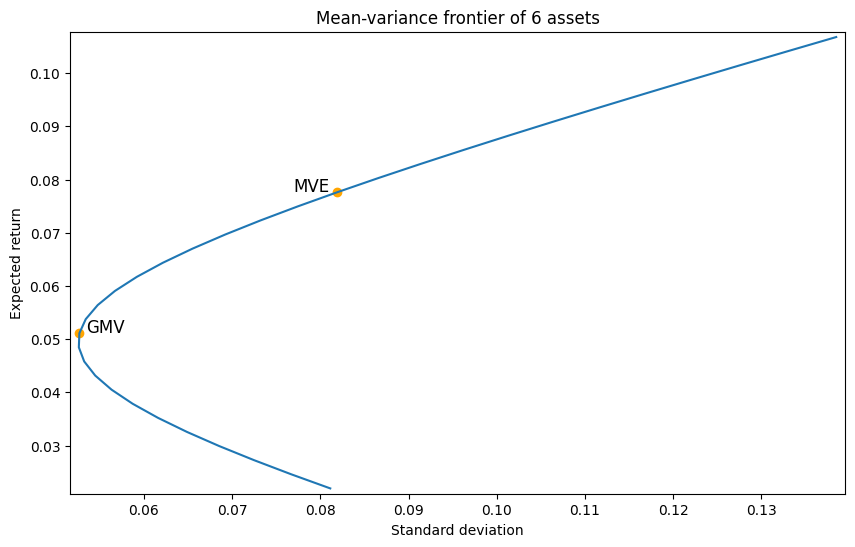

In [53]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,6))

# plot mean variance frontier
ax.plot(mvf['Deviation'], mvf['Return'])

# plot mean-variance efficient portfolio
ax.scatter(mve['Deviation'], mve['Return'], color='orange')
ax.text(mve['Deviation']-0.005, mve['Return']+0.0001, 'MVE', fontsize=12)

# plot global minimum variance portfolio
ax.scatter(gmv['Deviation'], gmv['Return'], color='orange')
ax.text(gmv['Deviation']+0.0008, gmv['Return']+0.0001, 'GMV', fontsize=12)

# add title and x/y-axis labels
plt.title('Mean-variance frontier of 6 assets')
plt.xlabel('Standard deviation')
plt.ylabel('Expected return')

# Set the limits of axes
plt.ylim(mvf['Return'].min() - 0.001, mvf['Return'].max()+0.001)
plt.xlim(mvf['Deviation'].min() - 0.001, mvf['Deviation'].max()+0.001)

# Show the graph
plt.show()

## Find the capital allocation

Suppose you are advising a client whose risk aversion coefficient is 4. What allocation would you suggest to her?

In [58]:
w = (mve['Return'] - rf_return) / (4 * mve['Deviation']**2)
print(f'You should invest {w*100:.0f}% of your wealth in the MVE portfolio.')

You should invest 177% of your wealth in the MVE portfolio.


The optimal capital allocation for an investor with a risk aversion coefficient of $A$ is given by:

$$
w = \frac{E(r_{mve}) - r_f}{A\sigma_{mve}^2}
$$

Plugging in the values 

$$
w = \frac{0.0776 - 0.03}{4 \times 0.0819^2} = 1.7736
$$

This suggests that she should invest 177% of her wealth in the MVE portfolio by borrowing 77%.